# **텍스트 요약**

**내장 체인(built-in chains)** 과 [LangGraph](https://langchain-ai.github.io/langgraph/)를 사용하여 **텍스트 요약**을 시연합니다.  

PDF, Notion 페이지, 고객 질문 등 **여러 문서**를 가지고 있고 그 내용을 **요약** 하고 싶다고 가정해 봅시다.

**대규모 언어 모델(LLM)** 은 텍스트를 이해하고 요약하는 데 뛰어난 능력을 가지고 있어 이 작업에 매우 적합합니다.

**검색 증강 생성(Retrieval-Augmented Generation, RAG)** 측면에서 볼 때, 텍스트를 요약하는 것은 많은 수의 검색된 문서에서 **핵심 정보를 추출**하여 LLM에 컨텍스트를 제공하는 데 도움을 줄 수 있습니다.

 **여러 문서의 내용을 LLM을 사용하여 요약하는 방법**을 단계별로 살펴보겠습니다.

![Image description](https://github.com/langchain-ai/langchain/blob/master/docs/static/img/summarization_use_case_1.png?raw=1)

여기에서 다룰 개념은 다음과 같습니다:

- **언어 모델**의 사용.

- **문서 로더**의 사용, 특히 [**WebBaseLoader**](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html)를 사용해 HTML 웹페이지의 콘텐츠를 로드하는 방법.

- **문서를 요약하거나 결합하는 두 가지 방법:**
   1. **Stuff**: 문서를 단순히 프롬프트에 연결합니다.  
   2. **Map-Reduce**: 더 많은 문서 집합에 사용됩니다. 문서를 배치로 나눈 후 각 배치를 요약하고, 마지막으로 요약된 결과를 다시 요약합니다.  


**summarizer**를 구축할 때 중심이 되는 질문은 **어떻게 문서를 LLM의 컨텍스트 윈도우에 전달할 것인가?** 입니다. 이 문제를 해결하기 위한 두 가지 일반적인 접근 방식이 있습니다:

1. **`Stuff`:**  
   - 모든 문서를 **하나의 프롬프트에 "채워 넣는"** 가장 간단한 방법입니다.  
   - 이 방법은 단순하지만 대규모 문서에는 적합하지 않을 수 있습니다.  
<p></p>

2. **`Map-reduce`:**  
   - 먼저 각 문서를 개별적으로 요약하는 **"Map" 단계**를 거칩니다.  
   - 이후, 요약된 결과를 결합하여 최종 요약을 만드는 **"Reduce" 단계**를  수행합니다.  
<p></p>

**`Map-reduce`** 는 특히 **부분 문서(sub-document)** 의 이해가 **이전 맥락에 의존하지 않는 경우** 효과적입니다. 예를 들어, **여러 개의 짧은 문서 모음** 을 요약할 때 유용합니다.  

반면, 소설이나 연속된 흐름이 중요한 긴 텍스트를 요약할 때는 **반복적 개선(iterative refinement)** 접근 방식이 더 효과적일 수 있습니다.

![Image description](https://github.com/langchain-ai/langchain/blob/master/docs/static/img/summarization_use_case_2.png?raw=1)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
# LangSmith 추적 설정 활성화
os.environ["LANGSMITH_TRACING"] = "true"

먼저 문서를 불러옵니다. 블로그 게시글을 불러오기 위해 [**WebBaseLoader**](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html)를 사용할 것입니다.

In [2]:
from langchain_community.document_loaders import WebBaseLoader

#  WebBaseLoader 객체 생성
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")

# load(): 지정된 URL의 내용을 가져와 LangChain 문서 형식으로 변환
docs = loader.load()

len(docs[0].page_content)

USER_AGENT environment variable not set, consider setting it to identify your requests.


43904

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

###  **Stuff: 단일 LLM 호출로 요약하기**

[**`create_stuff_documents_chain`**](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.stuff.create_stuff_documents_chain.html)을 사용할 수 있습니다. 특히  **큰 컨텍스트 윈도우(Context Window)** 를 지원하는 모델을 사용할 때 유용합니다:

- 128k 토큰 OpenAI `gpt-4o` 
- 200k 토큰 Anthropic `claude-3-5-sonnet-20240620`

이 체인은 문서 목록을 가져와 **모든 문서를 하나의 프롬프트로 삽입**한 뒤, 그 프롬프트를 **LLM에 전달**합니다.

In [4]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

#  프롬프트 정의
prompt = ChatPromptTemplate(
    [("system", "다음을 간결하게 요약하세요, 한국어로 요약하세요.\\n\\n{context}")]
)

# 체인 인스턴스 생성
chain = create_stuff_documents_chain(llm, prompt)
     
# 체인 실행 (invoke)
result = chain.invoke({"context": docs})
print(result)

이 글에서는 LLM(대형 언어 모델)을 기반으로 한 자율 에이전트 시스템에 대해 설명하고 있습니다. LLM은 에이전트의 두뇌 역할을 하며, 주요 구성 요소로는 계획, 기억, 도구 사용이 있습니다. 

1. **계획**: 에이전트는 복잡한 작업을 더 작은 하위 목표로 분해하고, 과거 행동에 대한 자기 반성을 통해 학습하여 결과의 질을 향상시킵니다.
2. **기억**: 단기 기억과 장기 기억을 통해 정보를 저장하고 검색할 수 있으며, 외부 벡터 저장소를 활용하여 무한한 정보를 유지할 수 있습니다.
3. **도구 사용**: 에이전트는 외부 API를 호출하여 모델의 한계를 넘어서는 정보를 얻고, 다양한 작업을 수행할 수 있습니다.

이 시스템은 여러 도전 과제를 안고 있으며, 특히 제한된 맥락 길이, 장기 계획의 어려움, 자연어 인터페이스의 신뢰성 문제 등이 있습니다. 다양한 사례 연구를 통해 LLM 기반 에이전트의 가능성과 한계를 탐구하고 있습니다.


###  **스트리밍**

결과를 **토큰 단위로 스트리밍**할 수도 있습니다.

In [5]:
# 체인 실행 및 스트리밍
for token in chain.stream(
    {"context": docs}
):
    print(token, end="|")

|이| 글|에서는| L|LM|(|대|형| 언|어| 모델|)을| 기반|으로| 한| 자|율| 에|이|전|트| 시스템|에| 대해| 설명|하고| 있습니다|.| L|LM|은| 에|이|전|트|의| 두|뇌| 역할|을| 하|며|,| 주요| 구성| 요소|로|는| 계획|,| 메|모|리|,| 도|구| 사용|이| 있습니다|.| 

|1|.| **|계|획|**|:| 에|이|전|트|는| 복|잡|한| 작업|을| 더| 작은| 하|위| 목표|로| 분|해|하고|,| 과|거| 행동|에| 대한| 자기| 반|성을| 통해| 학|습|하여| 결과|의| 질|을| 향|상|시|킵|니다|.
|2|.| **|메|모|리|**|:| 단|기| 메|모|리|와| 장|기| 메|모|리|로| 나|뉘|며|,| 외|부| 벡|터| 저장|소|를| 통해| 정보를| 저장|하고| 검색|할| 수| 있습니다|.
|3|.| **|도|구| 사용|**|:| 에|이|전|트|는| 외|부| API|를| 호출|하여| 모델|의| 한|계를| 넘어| 추가| 정보를| 얻|고|,| 다양한| 작업|을| 수행|할| 수| 있습니다|.

|이| 시스템|은| 여러| 도|전| 과|제를| 안|고| 있으며|,| 특히| 제한|된| 맥|락| 길|이|,| 장|기| 계획|의| 어려|움|,| 자연|어| 인터|페|이스|의| 신|뢰|성| 문제| 등이| 있습니다|.| 다양한| 사례| 연구|와| 개|념| 증|명| 예|시|를| 통해| L|LM| 기반| 에|이|전|트|의| 가능|성과| 한|계를| 탐|구|하고| 있습니다|.||

--------------------
### **Map-Reduce: 병렬 처리를 통한 긴 텍스트 요약**

**Map-Reduce 접근법**에서는 먼저 각 문서를 **LLM을 사용하여 개별 요약(map 단계)** 한 후, 이러한 요약들을 **하나의 글로벌 요약으로 통합(reduce 단계)** 합니다.

**Map 단계**는 일반적으로 입력 문서에 대해 **병렬 처리**됩니다.

**LangGraph**는 `langchain-core`를 기반으로 구축되었으며, [**Map-Reduce**](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) 워크플로우를 지원하므로 이 문제를 해결하기에 매우 적합합니다:

- **LangGraph**는 각 단계(예: 연속적인 요약)가 **스트리밍될 수 있도록 지원**하여 실행을 더 세밀하게 제어할 수 있습니다.  
- **LangGraph**의 [**체크포인트(checkpointing)**](https://langchain-ai.github.io/langgraph/how-tos/persistence/) 기능은 오류 복구, 인간 검토(human-in-the-loop) 워크플로우 확장, 대화형 애플리케이션 통합을 더욱 쉽게 지원합니다.  
- **LangGraph**는 간단하고 유연하게 수정 및 확장할 수 있습니다. 아래에서 자세히 확인해보겠습니다.



### **Map 단계**

먼저 **Map 단계**에 사용할 **프롬프트**를 정의해 보겠습니다. 이 단계에서는 `stuff` 접근법과 동일한 요약 프롬프트를 사용할 수 있습니다.

In [6]:
from langchain_core.prompts import ChatPromptTemplate

# Map 단계에 사용할 프롬프트 정의
map_prompt = ChatPromptTemplate.from_messages(
    [("system", "다음을 간결하게 요약하세요. 한국어로 요약하세요.\\n\\n{context}")]
)

### **Reduce**

문서 매핑 결과를 받아 **하나의 출력으로 통합하는 프롬프트**를 정의합니다.

In [8]:
# Reduce 프롬프트 템플릿 정의
reduce_template = """
다음은 요약된 내용들의 모음입니다:
{docs}
이것들을 분석하여 주요 주제를 담은 최종 통합 요약으로 압축하세요.
"""

reduce_prompt = ChatPromptTemplate.from_messages(
    [("human", reduce_template)]
)

### **LangGraph를 통한 오케스트레이션**

아래에서는 문서 목록에 대해 요약(Map) 단계를 실행한 다음, 앞서 정의한 프롬프트를 사용해 결과를 통합(Reduce)하는 간단한 애플리케이션을 구현합니다.

**Map-Reduce 흐름**은 LLM의 **컨텍스트 윈도우(context window)** 보다 텍스트가 긴 경우 특히 유용합니다. 긴 텍스트의 경우, Reduce 단계에서 요약해야 할 컨텍스트가 **모델의 컨텍스트 윈도우 크기를 초과하지 않도록** 관리하는 메커니즘이 필요합니다.  

여기서는 요약을 **재귀적으로 "압축(collapsing)"** 하는 방식을 구현합니다:  
- 입력 텍스트는 **토큰 제한(token limit)** 에 따라 분할됩니다.  
- 각 부분(partition)에 대한 요약이 생성됩니다.  
- 이 단계는 요약된 결과의 총 길이가 원하는 한도 내에 도달할 때까지 반복됩니다.  
- 이를 통해 **임의 길이의 텍스트를 효과적으로 요약**할 수 있습니다.

먼저 블로그 게시글을 더 작은 **"하위 문서(sub documents)"** 로 분할합니다.

In [9]:
from langchain_text_splitters import CharacterTextSplitter

# OpenAI의 tiktoken 기반 인코딩을 적용
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,   
    chunk_overlap=0   
)

# 문서를 하위 문서로 분할
split_docs = text_splitter.split_documents(docs)

# 생성된 하위 문서의 개수 출력
len(split_docs)

Created a chunk of size 1003, which is longer than the specified 1000


14

------------
다음으로, **그래프(graph)** 를 정의합니다.  

여기서는 **"압축(collapsing)" 단계**를 설명하기 위해 인위적으로 **1,000 토큰**이라는 낮은 최대 토큰 길이를 설정합니다.

아래 코드에서 async 와 await 는 **비동기적으로 LLM을 호출** 하여 응답을 기다리고, 여러 문서를 **병렬**로 처리하는 역할을 합니다.

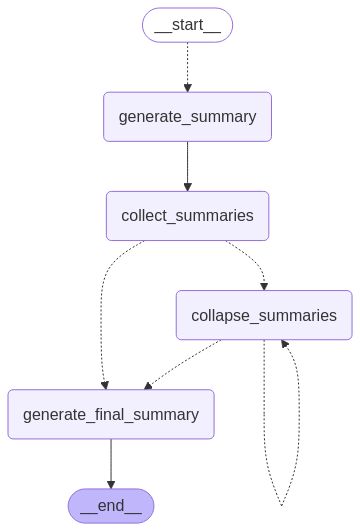

In [10]:
from langchain_core.documents import Document 
from langgraph.constants import Send   # 그래프 노드로 상태 전달을 하기 위한 Send 객체
from langgraph.graph import END, START, StateGraph   

import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,        # 문서를 압축(collapsing)하는 비동기 함수
    split_list_of_docs,    # 문서를 나누는 함수
)

# 최대 토큰 길이 설정
token_max = 1000

# 문서 길이 계산 함수
def length_function(documents: List[Document]) -> int:
    # 주어진 문서 목록의 총 토큰 수 반환
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)
    
# 전체적인 State 정의
# 문서 내용, 요약, 압축된 요약 및 최종 요약을 포함
class OverallState(TypedDict):
    contents: List[str]             # 원본 문서 내용 목록
    summaries: Annotated[list, operator.add]   # 개별 노드에서 생성된 요약을 합칠 때 사용
    collapsed_summaries: List[Document]      # 압축된 요약 목록
    final_summary: str           # 최종 요약 결과

# 각 문서 요약 단계의 상태 정의: 개별 문서를 처리하는 Map 단계에서 사용
class SummaryState(TypedDict):
    content: str      # 개별 문서 내용

# 개별 문서를 LLM에 전달하여 요약을 생성하는 비동기 함수 (Map 단계)
async def generate_summary(state: SummaryState):
    """
    state (SummaryState): 요약할 문서의 내용을 포함한 상태 객체
    state["content"]: 요약 대상 문서의 내용

    LLM이 생성한 요약 문자열을 리스트 형태로 반환
    """
    prompt = map_prompt.invoke(state["content"])   # 현재 문서의 내용이 프롬프트에 삽입
    response = await llm.ainvoke(prompt)  # LLM에게 요약 요청을 보내고 응답이 올 때까지 비동기적으로 대기
    return {"summaries": [response.content]}

# 문서에 대한 매핑 논리를 정의. graph의 edge 로 사용 예정.
def map_summaries(state: OverallState):
    # Send 객체의 리스트를 반환
    # 각 Send 객체는 그래프의 노드 이름과 해당 노드로 전달될 상태(state)로 구성
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]

# 요약 결과 수집:  Map 단계에서 생성된 요약을 수집하여 문서 객체로 변환
def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }

# Reduce 단계에서 최종 요약 생성
async def _reduce(input: dict) -> str:
    """
    여러 요약을 입력받아 최종적으로 통합된 요약을 생성
    input (dict): Reduce 단계에서 사용할 입력 데이터입니다.

    통합된 요약 결과 문자열 반환.
    """
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content

# 요약 압축 node 추가. 요약을 분할 및 재귀적으로 압축 
async def collapse_summaries(state: OverallState):
    """
    Map 단계에서 생성된 요약들을 토큰 제한에 맞게 병합
    state (OverallState): 전체 요약 상태를 담고 있는 객체입니다.
    병합된 요약 목록 반환.
    """
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))  #비동기 압축

    return {"collapsed_summaries": results}

# 요약 압축 여부 결정 (조건부 Edge)
# 토큰 수가 초과되면 'collapse_summaries'로 이동, 아니면 'generate_final_summary'로 이동
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"

# 최종 요약 생성 (Reduce 단계)
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}

# 그래프 구성
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)    # 개별 문서 요약 생성
graph.add_node("collect_summaries", collect_summaries)      # 요약 수집
graph.add_node("collapse_summaries", collapse_summaries)  # 요약 압축
graph.add_node("generate_final_summary", generate_final_summary)  # 최종 요약 생성

# 그래프 엣지(Edge) 정의
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

# 그래프 컴파일
app = graph.compile()
app

애플리케이션을 실행할 때 **그래프의 단계 순서**를 관찰하기 위해 스트리밍할 수 있습니다. 아래에서는 간단히 각 단계의 이름을 출력합니다.  

그래프에 **반복(loop)** 이 포함되어 있기 때문에, 실행 시 [**recursion_limit**](https://langchain-ai.github.io/langgraph/reference/errors/#langgraph.errors.GraphRecursionError)을 지정하는 것이 유용할 수 있습니다.  

지정된 한도를 초과하면 **GraphRecursionError**가 발생합니다.

In [11]:
# 그래프를 비동기 스트리밍 방식으로 실행  및 각 단계의 키 출력
# - app.astream: 그래프를 비동기적으로 실행하며 각 단계의 결과를 스트림으로 반환
# - {"contents": [doc.page_content for doc in split_docs]}: 초기 상태로 사용할 문서 내용 목록 전달
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},      # 재귀 호출 최대 횟수
):
    print(list(step.keys()))   # 각 단계에서 반환된 상태의 키(key) 목록을 출력

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']


In [12]:
print(step)

{'generate_final_summary': {'final_summary': '이 문서는 대규모 언어 모델(LLM) 기반 자율 에이전트 시스템과 항암제 개발 동향에 대한 내용을 다루고 있습니다. 주요 주제는 다음과 같습니다:\n\n1. **자율 에이전트 시스템**: LLM 기반의 자율 에이전트는 계획, 메모리, 도구 사용을 핵심 요소로 하여 복잡한 작업을 하위 목표로 나누고, Chain of Thought(CoT) 및 Tree of Thoughts(TOT) 기법을 통해 작업을 수행합니다. 자기 반성과 메모리는 과거의 결정을 개선하는 데 중요한 역할을 하며, 외부 API를 통해 최신 정보를 활용합니다.\n\n2. **유사도 검색 기술**: 고차원 데이터의 유사도를 효율적으로 검색하기 위한 다양한 해싱 기법과 알고리즘(LSH, ANNOY, HNSW, FAISS, ScaNN)이 소개됩니다.\n\n3. **신경-상징 아키텍처**: MRKL, TALM, Toolformer, HuggingGPT와 같은 시스템은 LLM과 외부 도구 API를 결합하여 질문 응답 및 작업 계획을 최적화합니다.\n\n4. **AI 어시스턴트와 벤치마크**: AI 어시스턴트는 사용자 요청에 대한 응답과 작업 프로세스를 설명해야 하며, API-Bank와 ChemCrow와 같은 벤치마크는 도구 보강 LLM의 성능을 평가하는 데 사용됩니다.\n\n5. **항암제 개발 동향**: 항암제 개발에서는 특정 화합물에 대한 스캐폴드 요청 및 합성 시도가 이루어지고 있으며, LLM 기반 자율 에이전트는 Generative Agents Simulation을 통해 인간 행동을 모사합니다. 그러나 LLM의 제한된 맥락 길이와 신뢰성 문제는 시스템 설계에 영향을 미칩니다.\n\n이 요약은 인공지능 기술의 다양한 응용 분야와 그에 따른 도전 과제를 포괄적으로 다루고 있습니다.'}}


In [16]:
print(step["generate_final_summary"]["final_summary"])

이 문서는 대규모 언어 모델(LLM) 기반 자율 에이전트 시스템과 항암제 개발 동향에 대한 내용을 다루고 있습니다. 주요 주제는 다음과 같습니다:

1. **자율 에이전트 시스템**: LLM 기반의 자율 에이전트는 계획, 메모리, 도구 사용을 핵심 요소로 하여 복잡한 작업을 하위 목표로 나누고, Chain of Thought(CoT) 및 Tree of Thoughts(TOT) 기법을 통해 작업을 수행합니다. 자기 반성과 메모리는 과거의 결정을 개선하는 데 중요한 역할을 하며, 외부 API를 통해 최신 정보를 활용합니다.

2. **유사도 검색 기술**: 고차원 데이터의 유사도를 효율적으로 검색하기 위한 다양한 해싱 기법과 알고리즘(LSH, ANNOY, HNSW, FAISS, ScaNN)이 소개됩니다.

3. **신경-상징 아키텍처**: MRKL, TALM, Toolformer, HuggingGPT와 같은 시스템은 LLM과 외부 도구 API를 결합하여 질문 응답 및 작업 계획을 최적화합니다.

4. **AI 어시스턴트와 벤치마크**: AI 어시스턴트는 사용자 요청에 대한 응답과 작업 프로세스를 설명해야 하며, API-Bank와 ChemCrow와 같은 벤치마크는 도구 보강 LLM의 성능을 평가하는 데 사용됩니다.

5. **항암제 개발 동향**: 항암제 개발에서는 특정 화합물에 대한 스캐폴드 요청 및 합성 시도가 이루어지고 있으며, LLM 기반 자율 에이전트는 Generative Agents Simulation을 통해 인간 행동을 모사합니다. 그러나 LLM의 제한된 맥락 길이와 신뢰성 문제는 시스템 설계에 영향을 미칩니다.

이 요약은 인공지능 기술의 다양한 응용 분야와 그에 따른 도전 과제를 포괄적으로 다루고 있습니다.


------------------
해당 [LangSmith 추적](https://smith.langchain.com/o/351c6cd9-1396-5c74-9478-1ee6a22a6433/projects/p/acec9d4d-4978-4597-adff-789cd42e200f?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=970686e5-ca1c-4f48-ada4-aa182bbb7b53)에서 각각의 노드 아래에 그룹화된 개별 LLM 호출을 확인할 수 있습니다.
